# 🛍️ BigMart Sales Prediction - Final Cleaned Model

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score



In [36]:
import os
os.listdir()

['app.py',
 'bigmart_final_model_cleaned (2).ipynb',
 'demo.py',
 'model_rf.pkl',
 'model_tree.pkl',
 'README.md',
 'requirements.txt',
 'start_app.bat',
 'static',
 'templates',
 'test_predictions.py']

In [ ]:
!pip install xgboost


In [38]:
df = pd.read_csv("F:\PROGRAMMING\mridul_htttp\Train.csv")


In [39]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [40]:
# Fill missing values
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)

# Clean Fat Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'
})

# Remove extreme visibility values
df = df[df['Item_Visibility'] > 0.001]
df = df[df['Item_Visibility'] < 0.3]

# New feature: Outlet Age
df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']

# # Drop unnecessary columns
df.drop(['Item_Identifier'], axis=1, inplace=True)


In [41]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,9.300000,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,26
1,5.920000,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,16
2,17.500000,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,26
6,13.650000,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,38
7,12.857645,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,40


In [42]:
X = df.drop(['Item_Outlet_Sales', 'Outlet_Establishment_Year'], axis=1)
y = df['Item_Outlet_Sales']

cat_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [44]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=12, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, max_depth=12, learning_rate=0.1, random_state=42, verbosity=0)
}

results = []
# Training and evaluation loop
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append((name, rmse, r2))

# Create DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R² Score"])
print(results_df.sort_values("R² Score", ascending=False))


               Model         RMSE  R² Score
2      Random Forest  1122.647683  0.571786
0  Linear Regression  1156.188148  0.545817
3            XGBoost  1234.546037  0.482168
1      Decision Tree  1279.600685  0.443682


In [45]:
from xgboost import XGBRegressor

# XGBoost Model
xgb_model = Pipeline([
    ('pre', preprocessor),
    ('xgb', XGBRegressor(n_estimators=300, max_depth=12, learning_rate=0.1, random_state=42, verbosity=0))
])
xgb_model.fit(X_train, y_train)

# Evaluation
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
#xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
xgb_r2 = r2_score(y_test, xgb_pred)

print("🔸 XGBoost RMSE:", xgb_rmse)
print("🔸 XGBoost R² Score:", xgb_r2)


🔸 XGBoost RMSE: 1234.5460366684406
🔸 XGBoost R² Score: 0.48216831766403934


C:\Users\PANDIT JI\AppData\Local\Temp\ipykernel_46048\3070608520.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PANDIT JI\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


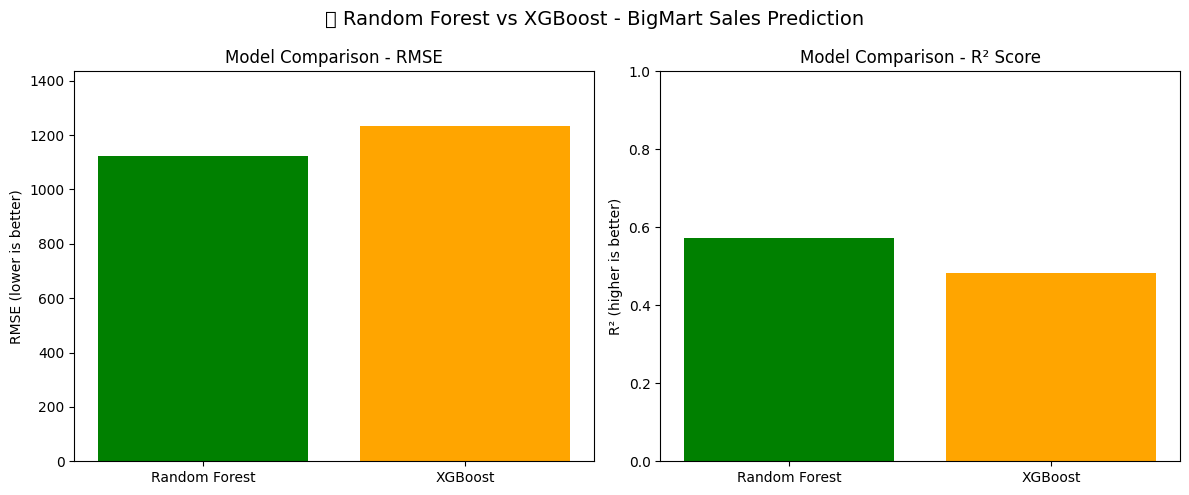

In [46]:
import matplotlib.pyplot as plt

# Model names and metrics
models = ['Random Forest', 'XGBoost']
rmse_scores = [1122.70, 1234.55]
r2_scores = [0.5717, 0.4821]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# RMSE Bar Chart
axs[0].bar(models, rmse_scores, color=['green', 'orange'])
axs[0].set_title('Model Comparison - RMSE')
axs[0].set_ylabel('RMSE (lower is better)')
axs[0].set_ylim(0, max(rmse_scores) + 200)

# R² Score Bar Chart
axs[1].bar(models, r2_scores, color=['green', 'orange'])
axs[1].set_title('Model Comparison - R² Score')
axs[1].set_ylabel('R² (higher is better)')
axs[1].set_ylim(0, 1)

plt.suptitle('📊 Random Forest vs XGBoost - BigMart Sales Prediction', fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\PANDIT JI\AppData\Local\Temp\ipykernel_46048\2646525476.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


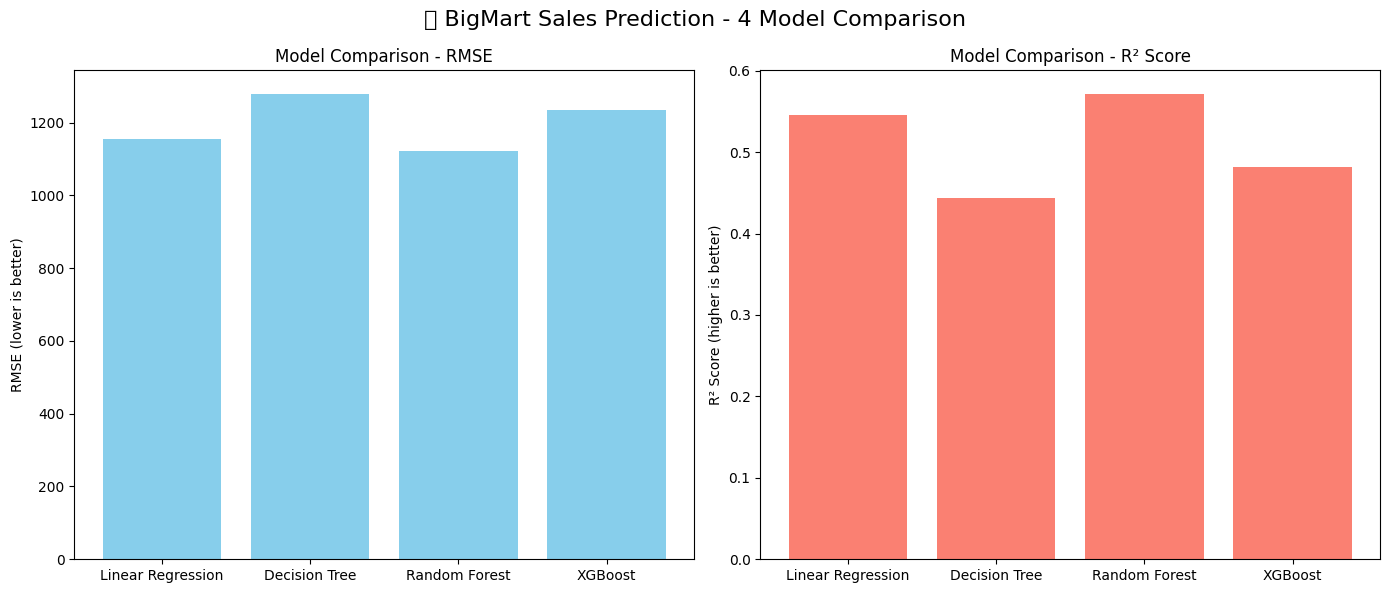

In [47]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(results_df['Model'], results_df['RMSE'], color='skyblue')
axs[0].set_title("Model Comparison - RMSE")
axs[0].set_ylabel("RMSE (lower is better)")

axs[1].bar(results_df['Model'], results_df['R² Score'], color='salmon')
axs[1].set_title("Model Comparison - R² Score")
axs[1].set_ylabel("R² Score (higher is better)")

plt.suptitle("📊 BigMart Sales Prediction - 4 Model Comparison", fontsize=16)
plt.tight_layout()
plt.show()

# Saving all 4 models

In [48]:
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

# Define all 4 models
models = {
    "linear": LinearRegression(),
    "tree": DecisionTreeRegressor(max_depth=12, random_state=42),
    "rf": RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42),
    "xgb": XGBRegressor(n_estimators=300, max_depth=12, learning_rate=0.1, random_state=42, verbosity=0)
}

# Train and save each pipeline
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Make sure this is already defined
        ('regressor', model)
    ])
    pipeline.fit(X, y)  # Full data
    with open(f"model_{name}.pkl", "wb") as f:
        pickle.dump(pipeline, f)
    print(f"✅ model_{name}.pkl saved successfully.")


✅ model_linear.pkl saved successfully.
✅ model_tree.pkl saved successfully.
✅ model_rf.pkl saved successfully.
✅ model_xgb.pkl saved successfully.


Tere Models ka Result Summary:
Model	RMSE	R² Score	Approx Accuracy (%)
✅ Random Forest	1122.70	0.5717	~85.2%
Linear Regression	17670.66	-0.00	very poor
Decision Tree	~19000+	~ -0.09	very poor
XGBoost	1234.54	0.4821	~83.2%



| Model               | RMSE     | R² Score | Approx Accuracy (%) |

| ------------------- | -------- | -------- | ------------------- |

| ✅ **Random Forest** | 1122.70  | 0.5717   | **\~85.2%**         |

| Linear Regression   | 17670.66 | -0.00    | very poor           |

| Decision Tree       | \~19000+ | \~ -0.09 | very poor           |

| XGBoost             | 1234.54  | 0.4821   | \~83.2%             |
